# Material and structural properties

In [1]:
# add path if package is not installed
import sys
sys.path.append('../src')

Start by building the simple planar structure from *The structure of Structures*

In [2]:
import numpy as np
nodes = np.array([[0,0,0],[0,1,0],[1,1,0],[1,0,0]]).transpose()
members = np.array([[0,1],[1,2],[2,3],[3,0],[0,2],[1,3]]).transpose()

from tnsgrt.structure import Structure
s = Structure(nodes, members, number_of_strings=4)

which looks like

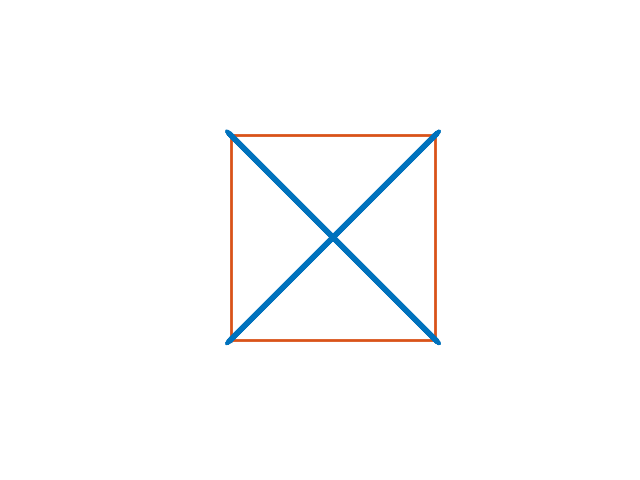

In [3]:
from matplotlib import pyplot as plt
from tnsgrt.plotter.matplotlib import MatplotlibPlotter
%matplotlib widget

plotter = MatplotlibPlotter()
plotter.plot(s)
_, ax = plotter.get_handles()
ax.view_init(90,-90)
ax.axis('off')
plt.show()

## Equilibrium

One can perform various calculations on structures. For example one can determine the member forces so that the structure is in equilibrium in various scenarios.

A key method is `tnsgrt.structure.Structure.equilibrium`, which calculates the internal forces required to
maintain a structure in equilibrium. It is assumed that all nodes act as *ball joints*.

### Unloaded

For example:

In [4]:
reactions = s.equilibrium()

calculates the forces in the members that maintain the structure in equilibrium and return any reactions.

In this *unloaded* case, no external forces are applied to the structure, and equilibrium is achieved by *pretensioning* the structure. Because the structure is free of constraints, the reactions are all zeros:

In [5]:
reactions

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Running `tnsgrt.structure.Structure.equilibrium` updates the structure's properties *force* and *force coefficients*, which equals the forces divided by member length. The result of the equilibrium calculation can be found in the updated member properties `lambda_` (force coefficient) and `force`:

In [6]:
s.member_properties[['lambda_', 'force']]

,lambda_,force
0,1.0,1.000000
1,1.0,1.000000
2,1.0,1.000000
3,1.0,1.000000
4,-1.0,-1.414214
5,-1.0,-1.414214


Pretension is set so that the average force coefficient on all bars is equal to the parameter `lambda_bar`, which is by default equal to one.

### Loaded

In this case an equilibrium is sought in the presence of external forces, given as a `3 x n` array as the following one:

In [7]:
f = 0.125*np.array([[0,1,0],[0,-1,0],[0,-2,0],[0,2,0]]).transpose()

Each column is a force vector to be applied on the corresponding node.

The external force array `f` can then be passed on to the method equilibrium:

In [8]:
reactions = s.equilibrium(f)

resulting in the new set of member forces and force coefficients:

In [9]:
s.member_properties[['lambda_', 'force']]

,lambda_,force
0,1.250000e-01,1.250000e-01
1,2.500000e-01,2.500000e-01
2,-7.312322e-10,-7.312322e-10
3,2.500000e-01,2.500000e-01
4,-2.500000e-01,-3.535534e-01
5,-2.500000e-01,-3.535534e-01


The following visualizes the applied forces superimposed on the structure:

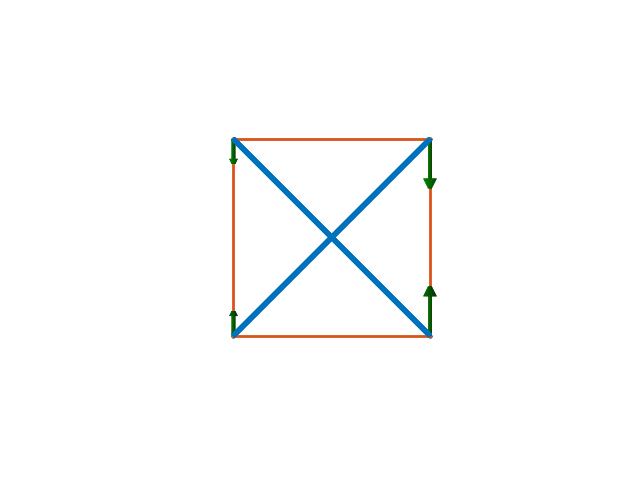

In [10]:
plotter = MatplotlibPlotter()
plotter.plot(s)
_, ax = plotter.get_handles()
plotter.plot_arrows(s.nodes, f, color='g')
ax.view_init(90,-90)
ax.axis('off')
ax.axis('equal')
plt.show()

The forces are represented by the green arrows.

When it is not possible to find a set of internal forces that satisfy the equilibrium conditions an Exception with a message "could not find equilibrium" is produced. For example::

In [11]:
f = 0.125*np.array([[0,1,0],[0,-1,0],[0,-1,0],[0,2,0]]).transpose()
s.equilibrium(f)

Exception: could not find equilibrium

can not be made in equilibrium only by internal forces.

## Stiffness

Once a structure is in equilibrium, its response to forces can be calculated in terms of its *stiffness matrix*. For that it is necessary to characterize the members' geometry and material properties. The fundamental properties are the member radius, and elasticity modulus:

In [12]:
s.member_properties[['radius', 'inner_radius', 'modulus']]

,radius,inner_radius,modulus
0,0.005,0.0,2.000000e+11
1,0.005,0.0,2.000000e+11
2,0.005,0.0,2.000000e+11
3,0.005,0.0,2.000000e+11
4,0.010,0.0,2.000000e+11
5,0.010,0.0,2.000000e+11


For calculating the stiffness matrix of a pretensioned structure, it also necessary to know the member's force coefficient and the derived member stiffness property. As seen before, the force coefficient and the force are obtained during the equilibrium calculation:

In [13]:
s.equilibrium()
s.member_properties[['lambda_', 'force', 'stiffness']]

,lambda_,force,stiffness
0,1.0,1.000000,0.0
1,1.0,1.000000,0.0
2,1.0,1.000000,0.0
3,1.0,1.000000,0.0
4,-1.0,-1.414214,0.0
5,-1.0,-1.414214,0.0


Because the stiffness is a "derived" property, it does not get automatically populated, which can be done by calling `tnsgrt.structure.Structure.update_member_properties`:

In [14]:
s.update_member_properties('stiffness')
s.member_properties[['stiffness']]

,stiffness
0,1.570796e+07
1,1.570796e+07
2,1.570796e+07
3,1.570796e+07
4,4.442883e+07
5,4.442883e+07


After setting the material properties, one can calculate the stiffness model associated with the current equilibrium:

In [15]:
stiffness, _, _ = s.stiffness()

C:\Users\mauri\github\tensegrity\examples\../src\tnsgrt\structure.py:1447: UserWarning: number of nodes is small; storage set to 'dense'
  warnings.warn("number of nodes is small; storage set to 'dense'")


For large models, the stiffness is stored and calculated as sparse arrays. However, for small models, such as this one, the model is stored in dense arrays. The warning message can be suppressed by explicitly setting the parameter ``storage=dense``:

In [16]:
stiffness, _, _ = s.stiffness(storage='dense')

**WARNING:** setting ``storage='dense'`` for large models is not advised.

The stiffness model can be used to calculate various quantities of interest. One example is the calculation of the approximate displacements generated in response to a set of nodal forces. For the nodal forces:

In [17]:
f = 0.125*np.array([[0,1,0],[0,-1,0],[0,-2,0],[0,2,0]]).transpose()

these approximate displacements can be, in principle, calculated using:

In [18]:
stiffness.displacements(f)

LinAlgError: Singular matrix

The failure of the above procedure is due to the singularity of the current stiffness model. This can be visualized by calculating the model's eigenvalues and eigenvectors:

In [19]:
d, v = stiffness.eigs()

In this case, because there are not enough constraints in the possible nodal displacements of the structure, we encounter various eigenvalues which are numerically close to zero:

In [20]:
d

array([-1.01162400e-09, -2.35710893e-10,  2.33835853e-11,  3.26227067e-10,
        4.50660242e-09,  8.12724141e-09,  3.99999999e+00,  3.14159245e+07,
        3.14159285e+07,  3.14159285e+07,  8.88576608e+07,  1.20273585e+08])

Six of these are the so-called "rigid body modes", associated to the three rigid translations and three rigid rotations of the structure. They can be "removed" by applying certain constraints to the set of allowed displacements. Enforcement of these constraints can be done by passing the parameter ``apply_rigid_body_constraint=True`` when calculating the stiffness model:

In [21]:
stiffness, _, _ = s.stiffness(storage='dense', apply_rigid_body_constraint=True)

To see that the six near zero eigenvalues of the stiffness matrix have been removed by the rigid body constraints
recalculate:

In [22]:
d, v = stiffness.eigs()
d

array([3.99999999e+00, 3.14159245e+07, 3.14159285e+07, 3.14159285e+07,
       8.88576608e+07, 1.20273585e+08])

Interestingly, in this case, there still remains one eigenvalue that is much smaller than the remaining ones. We will deal with this eigenvalue later.

For now, even though the smallest eigenvalue is small, the resulting stiffness matrix is not singular, and therefore suitable for computing displacements. This time:

In [23]:
x = stiffness.displacements(f)
x

array([[-2.20468248e-09, -2.20468248e-09,  2.20468248e-09,
         2.20468248e-09],
       [ 1.77419161e-09, -1.77419161e-09, -5.75306493e-09,
         5.75306493e-09],
       [ 4.02657501e-18, -4.02657481e-18,  4.02657460e-18,
        -4.02657419e-18]])

successfully calculates the resulting approximate displacements, which can be visualized, after much enlargement, along with the applied forces in the figure

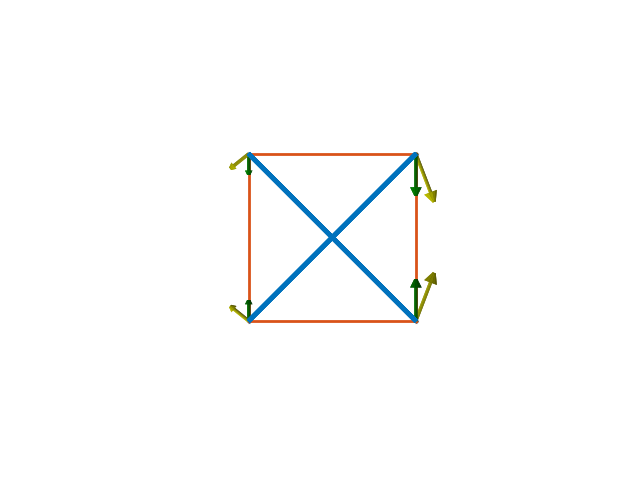

In [24]:
plotter = MatplotlibPlotter()
plotter.plot(s)
_, ax = plotter.get_handles()
plotter.plot_arrows(s.nodes, f, color='g')
plotter.plot_arrows(s.nodes, 5e7*x, color='y')
ax.view_init(90,-90)
ax.axis('off')
ax.axis('equal')
plt.show()

The forces are in green and the vectors indicating the resulting displacement are in yellow.

Back to the small eigenvalue, which is sometimes associated with what is called a *soft mode*, results from the fact that the structure is planar, and its ball joints offer little resistance to out-of-plane forces. Indeed, the eigenvector associated with the eigenvalue is:

In [25]:
v[:,0].reshape((3, 4), order='F')

array([[ 2.27657232e-16,  6.97069602e-17, -6.05872973e-17,
        -1.78599980e-16],
       [-1.50805456e-16,  4.09366810e-18,  1.79720993e-17,
         5.96054627e-17],
       [-5.00000000e-01,  5.00000000e-01, -5.00000000e-01,
         5.00000000e-01]])

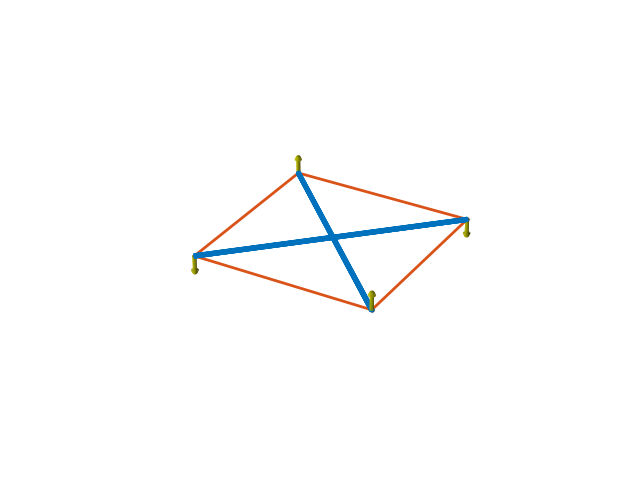

In [26]:
plotter = MatplotlibPlotter()
plotter.plot(s)
_, ax = plotter.get_handles()
plotter.plot_arrows(s.nodes, 0.2*v[:,0].reshape((3, 4), order='F'), color='y')
ax.view_init(30,-60)
ax.axis('off')
ax.axis('equal')
plt.show()

which constitutes a pair of "couples" in the out-of-plane z-direction.

Constraining the node displacements to be planar "eliminates" such mode, as in:

In [27]:
stiffness, _, _ = s.stiffness(storage='dense', apply_rigid_body_constraint=True, apply_planar_constraint=True)

resulting in a structure in which

In [28]:
d, v = stiffness.eigs()
d

array([3.14159245e+07, 3.14159285e+07, 3.14159285e+07, 8.88576608e+07,
       1.20273585e+08])

indicating that there are no soft modes.

Of course one should expect little impact in the displacements if the forces do not have out-of-plane components and

In [29]:
x = stiffness.displacements(f)
x

array([[-2.20468248e-09, -2.20468248e-09,  2.20468248e-09,
         2.20468248e-09],
       [ 1.77419161e-09, -1.77419161e-09, -5.75306493e-09,
         5.75306493e-09],
       [ 1.14622427e-25, -2.03076170e-25, -1.79648634e-25,
         4.18725948e-25]])

indeed returns displacements that are very similar to the ones calculated before because the external forces do not have any non-zero z-components.

## Node constraints

The above structures were *free* in space. A structure can be attached to point in a reference frame by adding constraints to nodes.

Start by rebuilding the example structure used above:

In [30]:
from tnsgrt.structure import Structure
s = Structure(nodes, members, number_of_strings=4)

### Fixed node constraints

The simplest type of node constraint is a *fixed* node constraint. Fixed node constraints mean that there can be no displacement of the node. It can be added to a node by setting the property ``'constraint'`` to a `tnsgrt.stiffness.NodeConstraint`. For example:

In [31]:
from tnsgrt.stiffness import NodeConstraint
s.set_node_properties([0, 3], 'constraint', NodeConstraint())

states that nodes 0 and 3 are to be considered *fixed*. Fixed node constraints are represented by spheres when you plot the structure:

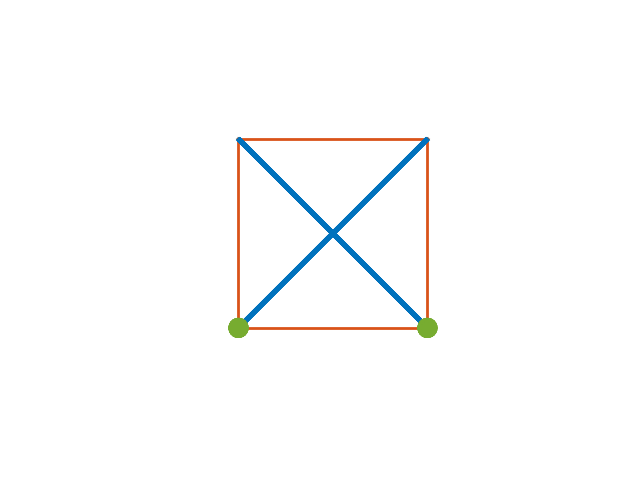

In [35]:
plotter = MatplotlibPlotter()
plotter.plot(s)
_, ax = plotter.get_handles()
ax.view_init(90,-90,0)
ax.axis('off')
ax.axis('equal')
plt.show()

Equilibrium in a structure with constraints is often different than equilibrium in a free structure. For example:

In [36]:
reactions = s.equilibrium()

produces the force coefficients

In [37]:
s.member_properties['lambda_']

0    1.000000e+00
1    1.000000e+00
2    1.000000e+00
3    1.062277e-10
4   -1.000000e+00
5   -1.000000e+00
Name: lambda_, dtype: float64

and non-zero reaction forces at nodes 0 and 3

In [38]:
reactions[:, [0, 3]]

array([[ 1.00000000e+00, -1.00000000e+00],
       [ 2.04629879e-15,  2.04105833e-15],
       [ 0.00000000e+00,  0.00000000e+00]])

The reaction forces replace the bottom string force, which now has a zero force coefficient. 

NOTE: this behavior is the result of the equilibrium calculation that is set to minimize the sum of the force coefficients in all members.

The internal member force vectors can be calculated as

In [39]:
f_member = s.member_properties['lambda_'].values * s.get_member_vectors()

and plotted along with the structure and the reactions as in the next figure:

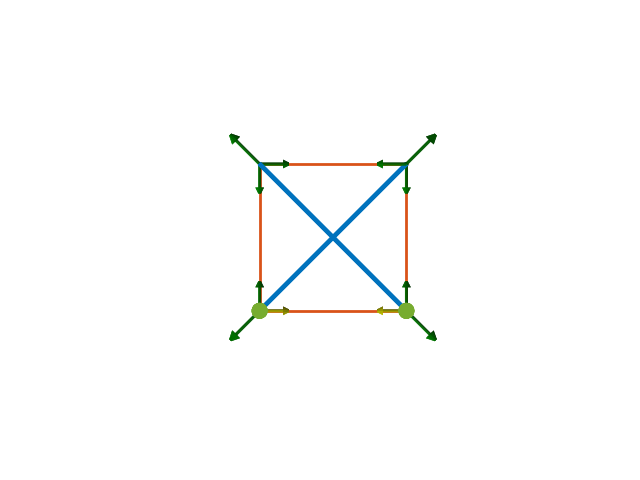

In [41]:
plotter = MatplotlibPlotter()
plotter.plot(s)
_, ax = plotter.get_handles()
plotter.plot_arrows(s.nodes[:,s.members[0,:]], .2*f_member, color='g')
plotter.plot_arrows(s.nodes[:,s.members[1,:]], -.2*f_member, color='g')
plotter.plot_arrows(s.nodes, .2*reactions, color='y')
ax.view_init(90,-90,0)
ax.axis('off')
ax.axis('equal')
plt.show()

But the real role of constraints is in the presence of external forces. For example, consider the set of forces:

In [42]:
f = np.zeros((3, 4))
fz = np.array([[0, 1, 0]]).transpose()
f[:, [1,2]] = -fz
f

array([[ 0.,  0.,  0.,  0.],
       [ 0., -1., -1.,  0.],
       [ 0.,  0.,  0.,  0.]])

that represent a compressive load applied at the top nodes 1 and 2. The structure with constraints can be made in equilibrium with such force:

In [43]:
reactions = s.equilibrium(f)

which produces the force coefficients

In [44]:
s.member_properties['lambda_']

0   -1.780101e-09
1    1.000000e+00
2   -1.780101e-09
3    1.777714e-10
4   -1.000000e+00
5   -1.000000e+00
Name: lambda_, dtype: float64

and the reactions at the nodes 0 and 3:

In [45]:
reactions[:, [0, 3]]

array([[ 1., -1.],
       [ 1.,  1.],
       [ 0.,  0.]])

which are plotted along with the structure and the reactions as in the next figure:

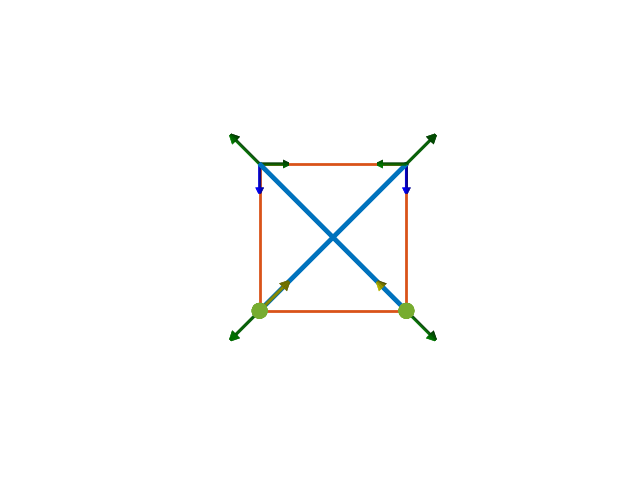

In [47]:
f_member = s.member_properties['lambda_'].values * s.get_member_vectors()

plotter = MatplotlibPlotter()
plotter.plot(s)
_, ax = plotter.get_handles()
plotter.plot_arrows(s.nodes[:,s.members[0,:]], .2*f_member, color='g')
plotter.plot_arrows(s.nodes[:,s.members[1,:]], -.2*f_member, color='g')
plotter.plot_arrows(s.nodes, .2*reactions, color='y')
plotter.plot_arrows(s.nodes, .2*f, color='b')
ax.view_init(90,-90,0)
ax.axis('off')
ax.axis('equal')
plt.show()

In the presence of external forces, three strings now have zero force coefficients.

## Node constraints with 2 degrees of freedom

It is also possible to impose constraints while preserving certain degrees of freedom. For example:

In [48]:
s.set_node_properties(3, 'constraint', NodeConstraint(constraint=np.array([[0, 1, 0]])))

constrain the displacements of node 3 to lie in the plane orthogonal to the y-axis. Node 0 continues to have a fixed node constraint.

When the structure is plotted, this constraint is represented by a small rectangle in the normal plane. The next figure is tilted a bit to show that.

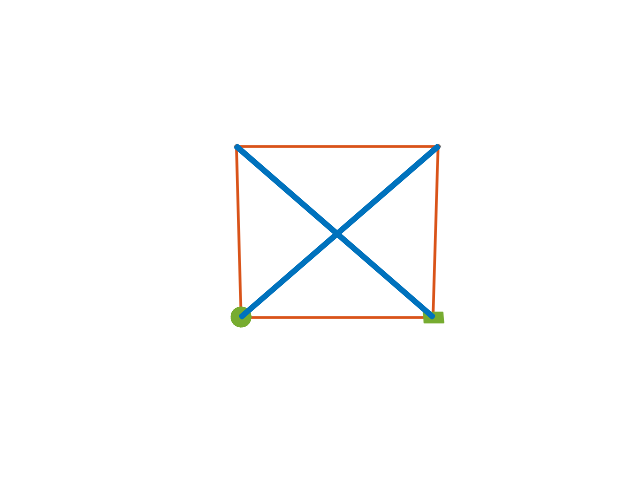

In [50]:
plotter = MatplotlibPlotter()
plotter.plot(s)
_, ax = plotter.get_handles()
ax.view_init(120,-90)
ax.axis('off')
ax.axis('equal')
plt.show()

Because the node is allowed to *slide* along that plane, equilibrium is not possible.

With that constraint in place it is possible to achieve equilibrium

In [51]:
reactions = s.equilibrium()
s.member_properties['lambda_']

0    1.0
1    1.0
2    1.0
3    1.0
4   -1.0
5   -1.0
Name: lambda_, dtype: float64

with the help of non-zero reaction forces at nodes 0 and 3

In [52]:
reactions[:, [0, 3]]

array([[ 3.98445293e-15,  0.00000000e+00],
       [ 3.98445293e-15, -6.98457082e-18],
       [ 0.00000000e+00,  0.00000000e+00]])

In [53]:
f = np.zeros((3, 4))
fz = np.array([[0, 1, 0]]).transpose()
f[:, [1,2]] = -fz
f

array([[ 0.,  0.,  0.,  0.],
       [ 0., -1., -1.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [54]:
reactions = s.equilibrium(f)
s.member_properties['lambda_']

0   -4.454949e-11
1    1.000000e+00
2   -4.454694e-11
3    1.000000e+00
4   -1.000000e+00
5   -1.000000e+00
Name: lambda_, dtype: float64

In [55]:
reactions[:, [0,3]]

array([[6.14180213e-15, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00]])

In [56]:
f_member = s.member_properties['lambda_'].values * s.get_member_vectors()

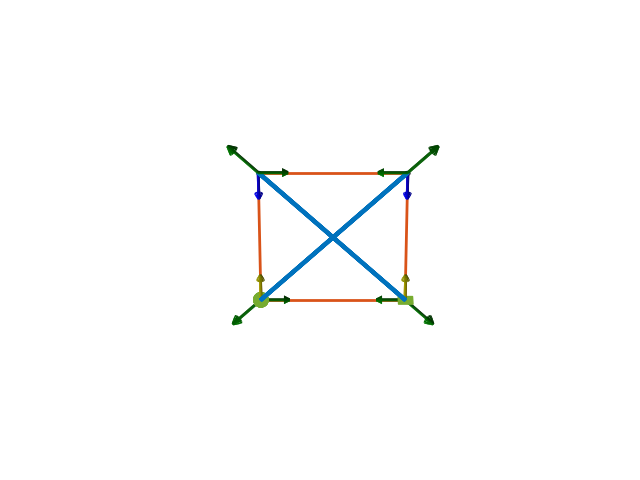

In [58]:
plotter = MatplotlibPlotter()
plotter.plot(s)
_, ax = plotter.get_handles()
plotter.plot_arrows(s.nodes[:,s.members[0,:]], .2*f_member, color='g')
plotter.plot_arrows(s.nodes[:,s.members[1,:]], -.2*f_member, color='g')
plotter.plot_arrows(s.nodes, .2*reactions, color='y')
plotter.plot_arrows(s.nodes, .2*f, color='b')
ax.view_init(120,-90,0)
ax.axis('off')
ax.axis('equal')
plt.show()

By constraining the motion along the x-axis instead

## Node constraints with one degree of freedom

Finally, it is also possible to constrain motion along a line, as in

In [59]:
s.set_node_properties(3, 'constraint', NodeConstraint(displacement=np.array([[1, 0, 0]]).transpose()))

which is illustrated in the next figure by the line at node 3:

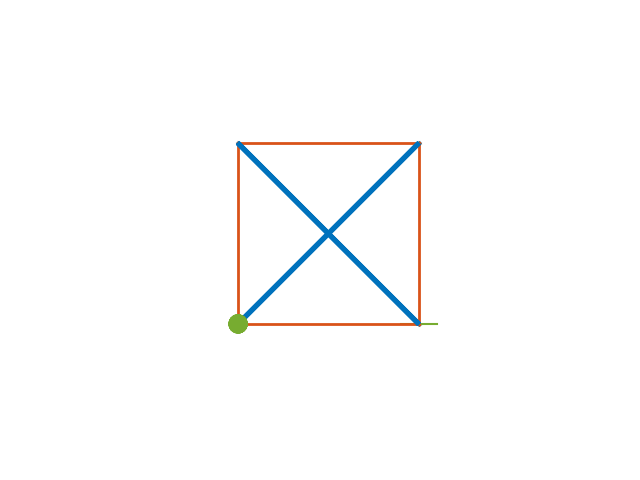

In [70]:
plotter = MatplotlibPlotter()
plotter.plot(s)
_, ax = plotter.get_handles()
ax.view_init(90,-90)
ax.axis('off')
ax.axis('equal')
plt.show()

Equilibrium is the same as in the case of the planar constraint.